## In this notebook, we try to see how class imbalance affects the accuracy of our classifier. We generate random samples for each class and fill out the deficit between the number of samples of each class and then see how our binary classifier performs with and without class imbalance.

In [ ]:
from tensorflow import keras
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path= '/content/drive/MyDrive/VOCtrainval_14-Jul-2008.tar'


import tarfile
with tarfile.open(path, 'r') as tar:
    tar.extractall()

# Preparing the dataset for the training

## Splitting data into train and test folders

In [ ]:
import shutil
import os
from sklearn.model_selection import train_test_split

folder_path = "/content/VOCdevkit/VOC2008/JPEGImages"
def extract_positive_images(directory, file_name):
    positive_images = []
    variations = [
        file_name,
        file_name.replace("_train", "_trainval"),
        file_name.replace("_train", "_val")
    ]

    for variation in variations:
        file_path = os.path.join(directory, variation)
        with open(file_path, "r") as file:
            lines = file.readlines()

        for line in lines:
            if line.strip().endswith(" 1"):
                image_name = line.split()[0] + ".jpg"
                if image_name not in positive_images:
                    positive_images.append(image_name)

    return positive_images


data_directory = "/content/VOCdevkit/VOC2008/ImageSets/Main"
folder_path = "/content/VOCdevkit/VOC2008/JPEGImages"

aeroplane_images = extract_positive_images(data_directory, "aeroplane_train.txt")
bicycle_images = extract_positive_images(data_directory, "bicycle_train.txt")
bird_images = extract_positive_images(data_directory, "bird_train.txt")
boat_images = extract_positive_images(data_directory, "boat_train.txt")
bottle_images = extract_positive_images(data_directory, "bottle_train.txt")
bus_images = extract_positive_images(data_directory, "bus_train.txt")
car_images = extract_positive_images(data_directory, "car_train.txt")
cat_images = extract_positive_images(data_directory, "cat_train.txt")
chair_images = extract_positive_images(data_directory, "chair_train.txt")
cow_images = extract_positive_images(data_directory, "cow_train.txt")
diningtable_images = extract_positive_images(data_directory, "diningtable_train.txt")
dog_images = extract_positive_images(data_directory, "dog_train.txt")
horse_images = extract_positive_images(data_directory, "horse_train.txt")
motorbike_images = extract_positive_images(data_directory, "motorbike_train.txt")
person_images = extract_positive_images(data_directory, "person_train.txt")
pottedplant_images = extract_positive_images(data_directory, "pottedplant_train.txt")
sheep_images = extract_positive_images(data_directory, "sheep_train.txt")
sofa_images = extract_positive_images(data_directory, "sofa_train.txt")
train_images = extract_positive_images(data_directory, "train_train.txt")
tvmonitor_images = extract_positive_images(data_directory, "tvmonitor_train.txt")

jpg_files = []

for file in os.listdir(folder_path):
    if file.endswith(".jpg"):
        jpg_files.append(file)


class_data_lists = {
    "Aeroplane": aeroplane_images,
    "Bicycle": bicycle_images,
    "Bird": bird_images,
    "Boat": boat_images,
    "Bottle": bottle_images,
    "Bus": bus_images,
    "Car": car_images,
    "Cat": cat_images,
    "Chair": chair_images,
    "Cow": cow_images,
    "Diningtable": diningtable_images,
    "Dog": dog_images,
    "Horse": horse_images,
    "Motorbike": motorbike_images,
    "Person": person_images,
    "Pottedplant": pottedplant_images,
    "Sheep": sheep_images,
    "Sofa": sofa_images,
    "Train": train_images,
    "Tvmonitor": tvmonitor_images
}


train_data_lists = {class_name: [] for class_name in class_data_lists}
test_data_lists = {class_name: [] for class_name in class_data_lists}


for class_name, data_list in class_data_lists.items():
    train_images, test_images = train_test_split(data_list, test_size=0.2, random_state=42)
    train_data_lists[class_name] = train_images
    test_data_lists[class_name] = test_images


for class_name, train_images in train_data_lists.items():
    for file in train_images:
        try:
            src_path = os.path.join(folder_path, file)
            dest_dir = os.path.join("/content/train", class_name)
            dest_path = os.path.join(dest_dir, file)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copyfile(src_path, dest_path)
        except Exception as e:
            print(f"Error copying {file} to {dest_dir}: {e}")


for class_name, test_images in test_data_lists.items():
    for file in test_images:
        try:
            src_path = os.path.join(folder_path, file)
            dest_dir = os.path.join("/content/test", class_name)
            dest_path = os.path.join(dest_dir, file)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copyfile(src_path, dest_path)
        except Exception as e:
            print(f"Error copying {file} to {dest_dir}: {e}")



In [ ]:
train_folder_path = "/content/train"
class_names = [d for d in os.listdir(train_folder_path) if os.path.isdir(os.path.join(train_folder_path, d))]
class_names

['Bus',
 'Tvmonitor',
 'Bottle',
 'Dog',
 'Cow',
 'Motorbike',
 'Sheep',
 'Car',
 'Diningtable',
 'Horse',
 'Pottedplant',
 'Aeroplane',
 'Person',
 'Boat',
 'Chair',
 'Train',
 'Bird',
 'Bicycle',
 'Cat',
 'Sofa']

In [ ]:
def create_class_subfolders(parent_folder):
    # Iterate through each class subfolder
    for class_folder in os.listdir(parent_folder):
        class_folder_path = os.path.join(parent_folder, class_folder)
        if os.path.isdir(class_folder_path):
            # Create a new subfolder with the same class name
            new_subfolder_path = os.path.join(class_folder_path, class_folder)
            os.makedirs(new_subfolder_path, exist_ok=True)

            # Copy all images from the class folder to the new subfolder
            for file_name in os.listdir(class_folder_path):
                file_path = os.path.join(class_folder_path, file_name)
                if os.path.isfile(file_path):
                    shutil.move(file_path, new_subfolder_path)

            print(f"Created subfolder for class '{class_folder}' in '{class_folder_path}'")

# Define the parent folder containing class subfolders
parent_folder = "/content/train"

# Call the function to create class subfolders and copy images
create_class_subfolders(parent_folder)

Created subfolder for class 'Bus' in '/content/train/Bus'
Created subfolder for class 'Tvmonitor' in '/content/train/Tvmonitor'
Created subfolder for class 'Bottle' in '/content/train/Bottle'
Created subfolder for class 'Dog' in '/content/train/Dog'
Created subfolder for class 'Cow' in '/content/train/Cow'
Created subfolder for class 'Motorbike' in '/content/train/Motorbike'
Created subfolder for class 'Sheep' in '/content/train/Sheep'
Created subfolder for class 'Car' in '/content/train/Car'
Created subfolder for class 'Diningtable' in '/content/train/Diningtable'
Created subfolder for class 'Horse' in '/content/train/Horse'
Created subfolder for class 'Pottedplant' in '/content/train/Pottedplant'
Created subfolder for class 'Aeroplane' in '/content/train/Aeroplane'
Created subfolder for class 'Person' in '/content/train/Person'
Created subfolder for class 'Boat' in '/content/train/Boat'
Created subfolder for class 'Chair' in '/content/train/Chair'
Created subfolder for class 'Train' 

In [ ]:
import os
import shutil

#for Test data

def create_class_subfolders(parent_folder):
    # Iterate through each class subfolder
    for class_folder in os.listdir(parent_folder):
        class_folder_path = os.path.join(parent_folder, class_folder)
        if os.path.isdir(class_folder_path):
            # Create a new subfolder with the same class name
            new_subfolder_path = os.path.join(class_folder_path, class_folder)
            os.makedirs(new_subfolder_path, exist_ok=True)

            # Copy all images from the class folder to the new subfolder
            for file_name in os.listdir(class_folder_path):
                file_path = os.path.join(class_folder_path, file_name)
                if os.path.isfile(file_path):
                    shutil.move(file_path, new_subfolder_path)

            print(f"Created subfolder for class '{class_folder}' in '{class_folder_path}'")



# Define the parent folder containing class subfolders
parent_folder = "/content/test"

# Call the function to create class subfolders and copy images
create_class_subfolders(parent_folder)

Created subfolder for class 'Bus' in '/content/test/Bus'
Created subfolder for class 'Tvmonitor' in '/content/test/Tvmonitor'
Created subfolder for class 'Bottle' in '/content/test/Bottle'
Created subfolder for class 'Dog' in '/content/test/Dog'
Created subfolder for class 'Cow' in '/content/test/Cow'
Created subfolder for class 'Motorbike' in '/content/test/Motorbike'
Created subfolder for class 'Sheep' in '/content/test/Sheep'
Created subfolder for class 'Car' in '/content/test/Car'
Created subfolder for class 'Diningtable' in '/content/test/Diningtable'
Created subfolder for class 'Horse' in '/content/test/Horse'
Created subfolder for class 'Pottedplant' in '/content/test/Pottedplant'
Created subfolder for class 'Aeroplane' in '/content/test/Aeroplane'
Created subfolder for class 'Person' in '/content/test/Person'
Created subfolder for class 'Boat' in '/content/test/Boat'
Created subfolder for class 'Chair' in '/content/test/Chair'
Created subfolder for class 'Train' in '/content/te

## Building The VAE

In [ ]:
EMBEDDING_DIM = 2
BETA = 1.0  # Weight for KL divergence in VAE loss
EPOCHS = 500  # Increase the number of epochs for better training
BATCH_SIZE = 16
FOLDER_PATH = '/content/models'  # Directory where trained models will be saved

In [ ]:
# Define the Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## VAE

In [ ]:
# Define the VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Encoder

In [ ]:
# Define the encoder
encoder_input = keras.Input(shape=(28, 28, 3))
x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(512, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1024, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 14, 14, 256)          7168      ['input_3[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 7, 7, 512)            1180160   ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 4, 4, 1024)           4719616   ['conv2d_5[0][0]']            
                                                                                            

## Decoder

In [ ]:
# Define the decoder
decoder_input = keras.Input(shape=(EMBEDDING_DIM,))
x = layers.Dense(7 * 7 * 1024, activation="relu")(decoder_input)
x = layers.Reshape((7, 7, 1024))(x)
x = layers.Conv2DTranspose(512, 3, strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(256, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(3, 3, strides=1, activation="sigmoid", padding="same")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 50176)             150528    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 1024)        0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 512)         4719104   
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 14, 14, 256)       1179904   
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 128)       2950

In [ ]:
encoder = keras.Model(encoder)
decoder = keras.Model(decoder)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))


In [ ]:
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)
IMAGE_SIZE = 28

In [ ]:

output_folder_path= "/content/generated_data-500samples"
output_folder= "/content/generated_data-500samples"
# Loop through each class and train the VAE model
for class_name in class_names:
    print(f"Training VAE for class: {class_name}")
    # encoder = keras.models.clone_model(encoder)
    # decoder = keras.models.clone_model(decoder)
    # Create a VAE instance
    vae = VAE(encoder, decoder)

    # Compile the VAE model
    optimizer = optimizers.Adam(learning_rate=0.001)
    vae.compile(optimizer=optimizer)

    # Create output folder if it doesn't exist
    os.makedirs(output_folder_path, exist_ok=True)

    # Configure the ImageDataGenerator for loading training data
    train_datagen = ImageDataGenerator(rescale=1./255)

    # Define the path to the class directory
    class_folder_path = os.path.join(train_folder_path, class_name)

    # Configure the ImageDataGenerator for loading training data
    train_datagen = ImageDataGenerator(rescale=1./255)

    # Load training data for the current class
    train_generator = train_datagen.flow_from_directory(
        directory=class_folder_path,
        classes=[class_name],
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=16,
        class_mode=None,  # No labels needed, only images
        shuffle=True
    )


    # Train the VAE model
    vae.fit(train_generator, epochs=300)
    test_folder_path = "/content/test"
    test_folder_path = os.path.join(test_folder_path, class_name)

    # target_size = (224, 224)


    test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0,1]

    test_generator = test_datagen.flow_from_directory(
    directory=test_folder_path,
    classes=[class_name],
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=16,
    class_mode=None,  # No labels needed, only images
    shuffle=True
    )


    latent_dim = 2  #latent space dimension is 2
    grid_width, grid_height = (50, 10)  #500 samples
    z_sample = np.random.normal(size=(grid_width * grid_height, EMBEDDING_DIM))

    # Decode the sampled points
    reconstructions = vae.decoder.predict(z_sample)


    # Create output subfolder for the current class
    class_output_folder = os.path.join(output_folder, class_name)
    os.makedirs(class_output_folder, exist_ok=True)

    # Save the resized images
    for i, image in enumerate(reconstructions):
        image_path = os.path.join(class_output_folder, f"image_{i+1}.jpg")
        # Convert image to uint8 format
        image_uint8 = (image * 255).astype(np.uint8)
        # Create PIL image from numpy array
        pil_image = Image.fromarray(image_uint8)
        # Save the image
        pil_image.save(image_path)




Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 1s 61ms/step - loss: 480.7077 - reconstruction_loss: 471.1973 - kl_loss: 6.2756
Epoch 219/300
12/12 [==============================] - 1s 64ms/step - loss: 474.3251 - reconstruction_loss: 470.5490 - kl_loss: 6.3631
Epoch 220/300
12/12 [==============================] - 1s 61ms/step - loss: 478.1544 - reconstruction_loss: 471.8739 - kl_loss: 6.2237
Epoch 221/300
12/12 [==============================] - 1s 63ms/step - loss: 477.2090 - reconstruction_loss: 471.3303 - kl_loss: 6.2812
Epoch 222/300
12/12 [==============================] - 1s 62ms/step - loss: 481.1284 - reconstruction_loss: 470.8113 - kl_loss: 6.4744
Epoch 223/300
12/12 [==============================] - 1s 65ms/step - loss: 471.7235 - reconstruction_loss: 470.3216 - kl_loss: 6.4007
Epoch 224/300
12/12 [==============================] - 1s 60ms/step - loss: 484.3993 - reconstruction_loss: 470.2520 - kl_loss: 6.1755
Epoch 225/300
12/1

In [ ]:
!zip -r /content/images.zip /content/generated_data-500samples


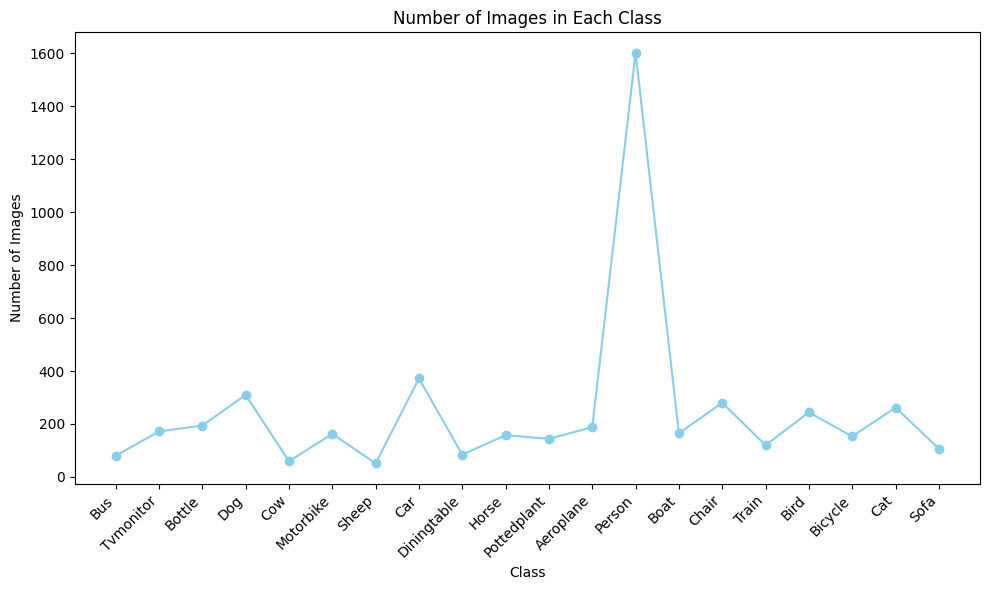

In [ ]:
import os
import matplotlib.pyplot as plt

# Path to the train directory
train_dir = "/content/train"

# Initialize empty lists to store class names and corresponding file counts
class_names = []
file_counts = []

# Traverse the train directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    class_dir = os.path.join(class_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of files in the class directory
        file_count = len(os.listdir(class_dir))
        class_names.append(class_name)
        file_counts.append(file_count)

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(class_names, file_counts, marker='o', color='skyblue', linestyle='-')
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
import zipfile
with zipfile.ZipFile("/content/images.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/generated_data-500samples")

In [ ]:
import os
import random
import shutil

# Function to count the number of files in a directory
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Function to copy random images from the generated folder to the first subfolder of each class
def copy_random_images(source_dir, dest_dir, num_images):
    images = os.listdir(source_dir)
    random_images = random.sample(images, num_images)
    for image in random_images:
        shutil.copy(os.path.join(source_dir, image), dest_dir)

# Path to the train directory
train_dir = "/content/train"

# Path to the generated folder
generated_dir = "/content/content/generated_data-500samples"

# Traverse each class folder, calculate deficit, and copy random images to fill deficit
for class_name in os.listdir(train_dir):
    class_subfolder1_dir = os.path.join(train_dir, class_name)
    class_subfolder1_dir = os.path.join(class_subfolder1_dir, class_name)
    class_generated_dir = os.path.join(generated_dir, class_name)

    # Find the maximum number of files among all class generated folders
    max_files = max(count_files(class_generated_dir) for class_name in os.listdir(train_dir))

    # Count the number of files in class subfolder 1
    num_files = count_files(class_subfolder1_dir)

    # Calculate deficit
    deficit = max_files - num_files
    if deficit > 0:
        print(f"Class: {class_name}, Deficit: {deficit}")
        copy_random_images(class_generated_dir, class_subfolder1_dir, deficit)


Class: Bus, Deficit: 420
Class: Tvmonitor, Deficit: 328
Class: Bottle, Deficit: 306
Class: Dog, Deficit: 190
Class: Cow, Deficit: 441
Class: Motorbike, Deficit: 337
Class: Sheep, Deficit: 449
Class: Car, Deficit: 128
Class: Diningtable, Deficit: 416
Class: Horse, Deficit: 342
Class: Pottedplant, Deficit: 356
Class: Aeroplane, Deficit: 312
Class: Boat, Deficit: 335
Class: Chair, Deficit: 220
Class: Train, Deficit: 380
Class: Bird, Deficit: 256
Class: Bicycle, Deficit: 347
Class: Cat, Deficit: 238
Class: Sofa, Deficit: 393


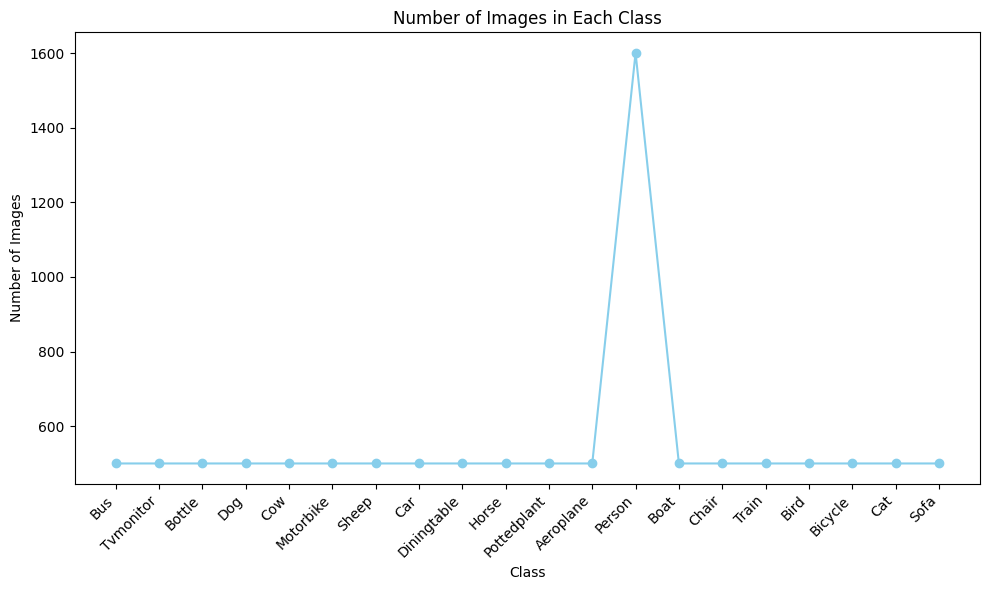

In [ ]:
import os
import matplotlib.pyplot as plt

# Path to the train directory
train_dir = "/content/train"

# Initialize empty lists to store class names and corresponding file counts
class_names = []
file_counts = []

# Traverse the train directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    class_dir = os.path.join(class_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of files in the class directory
        file_count = len(os.listdir(class_dir))
        class_names.append(class_name)
        file_counts.append(file_count)

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(class_names, file_counts, marker='o', color='skyblue', linestyle='-')
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Since the class person has 1600 images and we generated only 500, we cannot match the 1600 count, consequently we have removed random files from the person folder to make it even to the rest of the classes.

In [ ]:
import os
import random

def count_and_remove_files(directory):
    file_count = 0
    valid_files = []
    files_to_remove = []

    # Collecting files and counting valid files
    for filename in os.listdir(directory):
        if filename.startswith('2008_') or filename.startswith('2007_'):
            file_count += 1
            valid_files.append(filename)
        else:
            files_to_remove.append(filename)

    print("Total files before removal:", file_count)
    print("Valid files:", valid_files)

    # Calculating excess files to remove
    excess_files = file_count - 500

    print("Excess files to remove:", excess_files)

    # Remove excess files
    if excess_files > 0:
        random.shuffle(valid_files)
        files_to_remove.extend(valid_files[:excess_files])

        for filename in files_to_remove:
            os.remove(os.path.join(directory, filename))
            file_count -= 1

    return file_count

directory = '/content/train/Person/Person'
file_count = count_and_remove_files(directory)
print("Number of files after removal:", file_count)


Total files before removal: 1601
Valid files: ['2008_006078.jpg', '2008_007171.jpg', '2008_000795.jpg', '2008_003051.jpg', '2008_007918.jpg', '2008_005498.jpg', '2008_000090.jpg', '2008_002930.jpg', '2008_007443.jpg', '2008_003043.jpg', '2008_002558.jpg', '2008_003405.jpg', '2008_001182.jpg', '2008_001540.jpg', '2008_004749.jpg', '2008_007833.jpg', '2008_003146.jpg', '2008_008600.jpg', '2008_006117.jpg', '2008_001391.jpg', '2008_008185.jpg', '2008_003933.jpg', '2008_006708.jpg', '2008_005567.jpg', '2008_005501.jpg', '2008_007966.jpg', '2008_000677.jpg', '2008_001060.jpg', '2008_004778.jpg', '2008_000415.jpg', '2008_001068.jpg', '2008_000418.jpg', '2008_003208.jpg', '2008_008403.jpg', '2008_002956.jpg', '2008_004938.jpg', '2008_001349.jpg', '2008_000623.jpg', '2008_000376.jpg', '2008_002932.jpg', '2008_004522.jpg', '2008_002311.jpg', '2008_000854.jpg', '2008_006944.jpg', '2008_001206.jpg', '2008_007435.jpg', '2008_003154.jpg', '2008_003407.jpg', '2008_005790.jpg', '2008_003128.jpg', '20

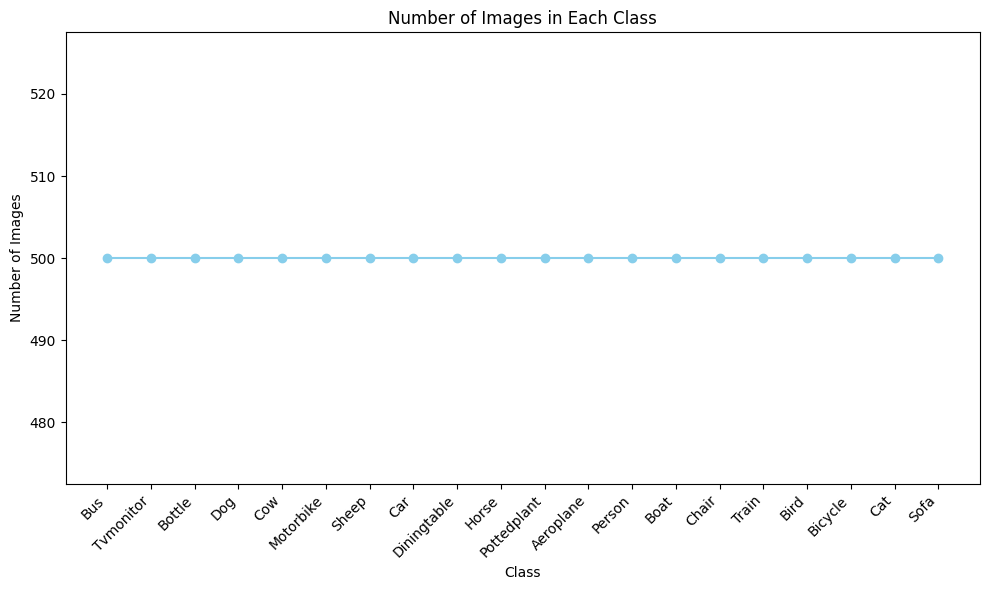

In [ ]:
import os
import matplotlib.pyplot as plt

# Path to the train directory
train_dir = "/content/train"

# Initialize empty lists to store class names and corresponding file counts
class_names = []
file_counts = []

# Traverse the train directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    class_dir = os.path.join(class_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of files in the class directory
        file_count = len(os.listdir(class_dir))
        class_names.append(class_name)
        file_counts.append(file_count)

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(class_names, file_counts, marker='o', color='skyblue', linestyle='-')
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


# Building the VAE

In [ ]:
import os
import shutil

# Define the path to the train directory
train_dir = "/content/train"

# Iterate over each subfolder in the train directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)

    # Check if the item in the directory is a subfolder
    if os.path.isdir(class_dir):
        # Define the path to the subsubfolder
        subsubfolder_dir = os.path.join(class_dir, class_name)

        # Check if the subsubfolder exists
        if os.path.exists(subsubfolder_dir):
            # Iterate over each file in the subsubfolder
            for file_name in os.listdir(subsubfolder_dir):
                file_path = os.path.join(subsubfolder_dir, file_name)

                # Define the destination path
                new_file_path = os.path.join(class_dir, file_name)

                # Check if the file already exists in the destination directory
                if not os.path.exists(new_file_path):
                    # Move the file to the parent subfolder
                    shutil.move(file_path, new_file_path)

            # Remove the empty subsubfolder
            os.rmdir(subsubfolder_dir)


In [ ]:
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set the paths to the train and test directories
train_folder_path = "/content/train"

# Each class has its own directory within the train directory
class_names = [d for d in os.listdir(train_folder_path) if os.path.isdir(os.path.join(train_folder_path, d))]

# Create a dictionary to hold our training image paths
train_data_lists = {class_name: [os.path.join(train_folder_path, class_name, img)
                                 for img in os.listdir(os.path.join(train_folder_path, class_name))]
                    for class_name in class_names}

def build_binary_classification_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Configure the ImageDataGenerator for training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

## Since even after balancing each class, when iniating training for binary classifier, we still have imbalance classes as it is 1 class(Positive) vs 19 classes(Negative), so we reduce the of number negative samples to the number of postive samples

In [ ]:
# Loop through each class and train a binary classification model
for class_name in class_names:
    print(f"Training for class: {class_name}")

    # Retrieve the list of image paths for the positive class
    positive_images = train_data_lists[class_name]
    if not positive_images:
        print(f"No images found for class {class_name}. Skipping this class.")
        continue
    positive_labels = [1] * len(positive_images)

    # Build a list of image paths for the negative class (all other classes)
    negative_images = []
    for other_class_name, image_paths in train_data_lists.items():
        if other_class_name != class_name:
            negative_images.extend(image_paths)

    print(f"Number of positive samples for {class_name}: {len(positive_images)}")
    print(f"Number of negative samples before balancing: {len(negative_images)}")


    random.shuffle(negative_images)  # Shuffle the negative images
    negative_images = negative_images[:len(positive_images)]  # Balance the positive and negative datasets
    negative_labels = [0] * len(negative_images)
    print(f"Number of negative samples after balancing: {len(negative_images)}")

    # Combine and shuffle the positive and negative samples
    combined_images = positive_images + negative_images
    combined_labels = positive_labels + negative_labels
    combined_list = list(zip(combined_images, combined_labels))
    random.shuffle(combined_list)
    combined_images, combined_labels = zip(*combined_list)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)

    # Create DataFrames for the training and validation sets
    train_df = pd.DataFrame({
    'filename': X_train,
    'label': [str(label) for label in y_train]  # Convert labels to strings
})
    val_df = pd.DataFrame({
    'filename': X_val,
    'label': [str(label) for label in y_val]  # Convert labels to strings
})

    # Create data generators for training and validation
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    #Build the binary classification model
    model = build_binary_classification_model()

    # Train the model on the data
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // 32,
        validation_data=val_generator,
        validation_steps=len(X_val) // 32,
        epochs=10
    )

    # Save the trained model
    model_save_path = os.path.join('models', f"{class_name}_binary_model.h5")
    os.makedirs('models', exist_ok=True)
    model.save(model_save_path)

    print(f"Finished training for class: {class_name}")

Training for class: Bus
Number of positive samples for Bus: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
25/25 [==============================] - 41s 589ms/step - loss: 0.4048 - accuracy: 0.8000 - val_loss: 0.4266 - val_accuracy: 0.8698
Epoch 2/10
25/25 [==============================] - 15s 607ms/step - loss: 0.3515 - accuracy: 0.8525 - val_loss: 0.3090 - val_accuracy: 0.8594
Epoch 3/10
25/25 [==============================] - 16s 605ms/step - loss: 0.1721 - accuracy: 0.9413 - val_loss: 0.1857 - val_accuracy: 0.9375
Epoch 4/10
25/25 [==============================] - 15s 607ms/step - loss: 0.1498 - accuracy: 0.9400 - val_loss: 0.3710 - val_accuracy: 0.8750
Epoch 5/10
25/25 [==============================] - 16s 609ms/step - loss: 0.1399

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Bus
Training for class: Tvmonitor
Number of positive samples for Tvmonitor: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 22s 598ms/step - loss: 0.7221 - accuracy: 0.5750 - val_loss: 0.6732 - val_accuracy: 0.5521
Epoch 2/10
25/25 [==============================] - 16s 623ms/step - loss: 0.5896 - accuracy: 0.6625 - val_loss: 0.5226 - val_accuracy: 0.7396
Epoch 3/10
25/25 [==============================] - 15s 596ms/step - loss: 0.5093 - accuracy: 0.7550 - val_loss: 0.5301 - val_accuracy: 0.7500
Epoch 4/10
25/25 [==============================] - 16s 616ms/step - loss: 0.4562 - accuracy: 0.7788 - val_loss: 0.4513 - val_accuracy: 0.7656
Epoch 5/10
25/25 [==============================] - 15s 605ms/step - loss: 0.4331 - accuracy: 0.7937 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Tvmonitor
Training for class: Bottle
Number of positive samples for Bottle: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 21s 609ms/step - loss: 0.6664 - accuracy: 0.5913 - val_loss: 0.6699 - val_accuracy: 0.5521
Epoch 2/10
25/25 [==============================] - 15s 611ms/step - loss: 0.5849 - accuracy: 0.6712 - val_loss: 0.6465 - val_accuracy: 0.5781
Epoch 3/10
25/25 [==============================] - 16s 620ms/step - loss: 0.5314 - accuracy: 0.7113 - val_loss: 0.5972 - val_accuracy: 0.6562
Epoch 4/10
25/25 [==============================] - 16s 606ms/step - loss: 0.4692 - accuracy: 0.7700 - val_loss: 0.4396 - val_accuracy: 0.7760
Epoch 5/10
25/25 [==============================] - 15s 599ms/step - loss: 0.4073 - accuracy: 0.8175 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Bottle
Training for class: Dog
Number of positive samples for Dog: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 19s 607ms/step - loss: 0.7233 - accuracy: 0.5325 - val_loss: 0.6822 - val_accuracy: 0.5312
Epoch 2/10
25/25 [==============================] - 16s 619ms/step - loss: 0.6602 - accuracy: 0.6263 - val_loss: 0.6653 - val_accuracy: 0.6042
Epoch 3/10
25/25 [==============================] - 17s 659ms/step - loss: 0.6332 - accuracy: 0.6513 - val_loss: 0.6016 - val_accuracy: 0.6667
Epoch 4/10
25/25 [==============================] - 16s 623ms/step - loss: 0.6006 - accuracy: 0.6925 - val_loss: 0.5760 - val_accuracy: 0.6823
Epoch 5/10
25/25 [==============================] - 15s 608ms/step - loss: 0.5901 - accuracy: 0.6888 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Dog
Training for class: Cow
Number of positive samples for Cow: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 20s 653ms/step - loss: 0.6147 - accuracy: 0.6438 - val_loss: 0.5397 - val_accuracy: 0.7708
Epoch 2/10
25/25 [==============================] - 16s 615ms/step - loss: 0.4417 - accuracy: 0.8112 - val_loss: 0.6794 - val_accuracy: 0.6667
Epoch 3/10
25/25 [==============================] - 15s 593ms/step - loss: 0.4064 - accuracy: 0.8275 - val_loss: 0.3866 - val_accuracy: 0.8333
Epoch 4/10
25/25 [==============================] - 15s 613ms/step - loss: 0.4083 - accuracy: 0.8375 - val_loss: 0.3375 - val_accuracy: 0.8646
Epoch 5/10
25/25 [==============================] - 15s 601ms/step - loss: 0.2756 - accuracy: 0.9025 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Cow
Training for class: Motorbike
Number of positive samples for Motorbike: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 20s 595ms/step - loss: 0.7098 - accuracy: 0.4988 - val_loss: 0.6916 - val_accuracy: 0.5104
Epoch 2/10
25/25 [==============================] - 16s 620ms/step - loss: 0.6933 - accuracy: 0.5188 - val_loss: 0.6834 - val_accuracy: 0.5365
Epoch 3/10
25/25 [==============================] - 16s 606ms/step - loss: 0.6942 - accuracy: 0.5325 - val_loss: 0.6941 - val_accuracy: 0.5052
Epoch 4/10
25/25 [==============================] - 16s 606ms/step - loss: 0.6983 - accuracy: 0.5138 - val_loss: 0.7349 - val_accuracy: 0.5156
Epoch 5/10
25/25 [==============================] - 15s 608ms/step - loss: 0.6943 - accuracy: 0.5775 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Motorbike
Training for class: Sheep
Number of positive samples for Sheep: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 19s 602ms/step - loss: 0.6544 - accuracy: 0.6087 - val_loss: 0.6592 - val_accuracy: 0.6146
Epoch 2/10
25/25 [==============================] - 15s 605ms/step - loss: 0.5975 - accuracy: 0.6925 - val_loss: 0.5213 - val_accuracy: 0.7240
Epoch 3/10
25/25 [==============================] - 15s 596ms/step - loss: 0.4217 - accuracy: 0.8225 - val_loss: 0.2869 - val_accuracy: 0.8750
Epoch 4/10
25/25 [==============================] - 17s 662ms/step - loss: 0.2455 - accuracy: 0.9175 - val_loss: 0.2350 - val_accuracy: 0.9219
Epoch 5/10
25/25 [==============================] - 15s 592ms/step - loss: 0.2099 - accuracy: 0.9225 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Sheep
Training for class: Car
Number of positive samples for Car: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 19s 608ms/step - loss: 0.6842 - accuracy: 0.6212 - val_loss: 0.5888 - val_accuracy: 0.7135
Epoch 2/10
25/25 [==============================] - 17s 646ms/step - loss: 0.5629 - accuracy: 0.7075 - val_loss: 0.5437 - val_accuracy: 0.7240
Epoch 3/10
25/25 [==============================] - 16s 614ms/step - loss: 0.5312 - accuracy: 0.7375 - val_loss: 0.5514 - val_accuracy: 0.7240
Epoch 4/10
25/25 [==============================] - 16s 636ms/step - loss: 0.4963 - accuracy: 0.7650 - val_loss: 0.5158 - val_accuracy: 0.7448
Epoch 5/10
25/25 [==============================] - 16s 624ms/step - loss: 0.4739 - accuracy: 0.7738 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Car
Training for class: Diningtable
Number of positive samples for Diningtable: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 21s 601ms/step - loss: 0.7100 - accuracy: 0.5125 - val_loss: 0.6614 - val_accuracy: 0.6042
Epoch 2/10
25/25 [==============================] - 15s 614ms/step - loss: 0.6926 - accuracy: 0.5400 - val_loss: 0.7035 - val_accuracy: 0.4948
Epoch 3/10
25/25 [==============================] - 16s 618ms/step - loss: 0.6822 - accuracy: 0.5587 - val_loss: 0.6318 - val_accuracy: 0.7188
Epoch 4/10
25/25 [==============================] - 15s 596ms/step - loss: 0.6041 - accuracy: 0.6888 - val_loss: 0.6110 - val_accuracy: 0.5625
Epoch 5/10
25/25 [==============================] - 16s 611ms/step - loss: 0.6053 - accuracy: 0.6

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Diningtable
Training for class: Horse
Number of positive samples for Horse: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 21s 596ms/step - loss: 0.7277 - accuracy: 0.5213 - val_loss: 0.6925 - val_accuracy: 0.5208
Epoch 2/10
25/25 [==============================] - 16s 621ms/step - loss: 0.6935 - accuracy: 0.5225 - val_loss: 0.6906 - val_accuracy: 0.4896
Epoch 3/10
25/25 [==============================] - 15s 595ms/step - loss: 0.6818 - accuracy: 0.5700 - val_loss: 0.6724 - val_accuracy: 0.5625
Epoch 4/10
25/25 [==============================] - 15s 588ms/step - loss: 0.6778 - accuracy: 0.5700 - val_loss: 0.6809 - val_accuracy: 0.6354
Epoch 5/10
25/25 [==============================] - 16s 634ms/step - loss: 0.6693 - accuracy: 0.6125 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Horse
Training for class: Pottedplant
Number of positive samples for Pottedplant: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 19s 596ms/step - loss: 0.7141 - accuracy: 0.5163 - val_loss: 0.6916 - val_accuracy: 0.5469
Epoch 2/10
25/25 [==============================] - 16s 630ms/step - loss: 0.6958 - accuracy: 0.5175 - val_loss: 0.7163 - val_accuracy: 0.4635
Epoch 3/10
25/25 [==============================] - 16s 627ms/step - loss: 0.6996 - accuracy: 0.5088 - val_loss: 0.6879 - val_accuracy: 0.5417
Epoch 4/10
25/25 [==============================] - 16s 617ms/step - loss: 0.6947 - accuracy: 0.5400 - val_loss: 0.6944 - val_accuracy: 0.4531
Epoch 5/10
25/25 [==============================] - 16s 620ms/step - loss: 0.6818 - accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Pottedplant
Training for class: Aeroplane
Number of positive samples for Aeroplane: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 21s 618ms/step - loss: 0.5500 - accuracy: 0.7225 - val_loss: 0.6625 - val_accuracy: 0.6719
Epoch 2/10
25/25 [==============================] - 15s 604ms/step - loss: 0.3840 - accuracy: 0.8250 - val_loss: 0.3253 - val_accuracy: 0.8698
Epoch 3/10
25/25 [==============================] - 16s 620ms/step - loss: 0.3112 - accuracy: 0.8700 - val_loss: 0.2995 - val_accuracy: 0.8646
Epoch 4/10
25/25 [==============================] - 16s 616ms/step - loss: 0.2663 - accuracy: 0.9050 - val_loss: 0.2576 - val_accuracy: 0.9062
Epoch 5/10
25/25 [==============================] - 16s 620ms/step - loss: 0.2161 - accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Aeroplane
Training for class: Person
Number of positive samples for Person: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 20s 626ms/step - loss: 0.5719 - accuracy: 0.6850 - val_loss: 0.5833 - val_accuracy: 0.6927
Epoch 2/10
25/25 [==============================] - 16s 645ms/step - loss: 0.4178 - accuracy: 0.8125 - val_loss: 0.3948 - val_accuracy: 0.8073
Epoch 3/10
25/25 [==============================] - 17s 646ms/step - loss: 0.3675 - accuracy: 0.8350 - val_loss: 0.3559 - val_accuracy: 0.8385
Epoch 4/10
25/25 [==============================] - 16s 641ms/step - loss: 0.3435 - accuracy: 0.8450 - val_loss: 0.3755 - val_accuracy: 0.8490
Epoch 5/10
25/25 [==============================] - 16s 627ms/step - loss: 0.3119 - accuracy: 0.8525 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Person
Training for class: Boat
Number of positive samples for Boat: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 19s 598ms/step - loss: 0.6925 - accuracy: 0.5888 - val_loss: 0.5659 - val_accuracy: 0.7240
Epoch 2/10
25/25 [==============================] - 15s 599ms/step - loss: 0.5714 - accuracy: 0.7250 - val_loss: 0.4963 - val_accuracy: 0.7708
Epoch 3/10
25/25 [==============================] - 15s 611ms/step - loss: 0.5930 - accuracy: 0.7163 - val_loss: 0.5158 - val_accuracy: 0.8333
Epoch 4/10
25/25 [==============================] - 15s 601ms/step - loss: 0.4025 - accuracy: 0.8388 - val_loss: 0.3677 - val_accuracy: 0.8594
Epoch 5/10
25/25 [==============================] - 15s 600ms/step - loss: 0.3105 - accuracy: 0.8725 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Boat
Training for class: Chair
Number of positive samples for Chair: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 20s 620ms/step - loss: 0.7218 - accuracy: 0.5350 - val_loss: 0.6532 - val_accuracy: 0.6094
Epoch 2/10
25/25 [==============================] - 16s 615ms/step - loss: 0.6706 - accuracy: 0.5838 - val_loss: 0.6829 - val_accuracy: 0.5365
Epoch 3/10
25/25 [==============================] - 16s 616ms/step - loss: 0.6303 - accuracy: 0.6513 - val_loss: 0.6239 - val_accuracy: 0.6562
Epoch 4/10
25/25 [==============================] - 18s 685ms/step - loss: 0.6037 - accuracy: 0.6662 - val_loss: 0.5468 - val_accuracy: 0.7240
Epoch 5/10
25/25 [==============================] - 15s 607ms/step - loss: 0.5692 - accuracy: 0.6950 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Chair
Training for class: Train
Number of positive samples for Train: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 19s 597ms/step - loss: 0.6958 - accuracy: 0.5725 - val_loss: 0.7206 - val_accuracy: 0.4792
Epoch 2/10
25/25 [==============================] - 17s 672ms/step - loss: 0.6357 - accuracy: 0.6438 - val_loss: 0.5794 - val_accuracy: 0.7292
Epoch 3/10
25/25 [==============================] - 15s 603ms/step - loss: 0.5906 - accuracy: 0.6550 - val_loss: 0.4530 - val_accuracy: 0.7760
Epoch 4/10
25/25 [==============================] - 15s 599ms/step - loss: 0.5554 - accuracy: 0.7088 - val_loss: 0.4297 - val_accuracy: 0.8281
Epoch 5/10
25/25 [==============================] - 16s 619ms/step - loss: 0.4737 - accuracy: 0.7875 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Train
Training for class: Bird
Number of positive samples for Bird: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 20s 601ms/step - loss: 0.7097 - accuracy: 0.5525 - val_loss: 0.6724 - val_accuracy: 0.5885
Epoch 2/10
25/25 [==============================] - 16s 621ms/step - loss: 0.6423 - accuracy: 0.6413 - val_loss: 0.6474 - val_accuracy: 0.5885
Epoch 3/10
25/25 [==============================] - 16s 619ms/step - loss: 0.6106 - accuracy: 0.6712 - val_loss: 0.6557 - val_accuracy: 0.5938
Epoch 4/10
25/25 [==============================] - 16s 620ms/step - loss: 0.5602 - accuracy: 0.7262 - val_loss: 0.6057 - val_accuracy: 0.6250
Epoch 5/10
25/25 [==============================] - 15s 611ms/step - loss: 0.5638 - accuracy: 0.6950 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Bird
Training for class: Bicycle
Number of positive samples for Bicycle: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 20s 625ms/step - loss: 0.7151 - accuracy: 0.5400 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/10
25/25 [==============================] - 15s 601ms/step - loss: 0.6957 - accuracy: 0.5175 - val_loss: 0.6906 - val_accuracy: 0.5052
Epoch 3/10
25/25 [==============================] - 16s 611ms/step - loss: 0.6668 - accuracy: 0.5987 - val_loss: 0.6523 - val_accuracy: 0.6146
Epoch 4/10
25/25 [==============================] - 15s 598ms/step - loss: 0.6373 - accuracy: 0.6525 - val_loss: 0.6296 - val_accuracy: 0.6042
Epoch 5/10
25/25 [==============================] - 15s 599ms/step - loss: 0.6258 - accuracy: 0.6650 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Bicycle
Training for class: Cat
Number of positive samples for Cat: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 20s 607ms/step - loss: 0.6702 - accuracy: 0.6187 - val_loss: 0.6661 - val_accuracy: 0.6250
Epoch 2/10
25/25 [==============================] - 16s 625ms/step - loss: 0.5588 - accuracy: 0.6988 - val_loss: 0.5445 - val_accuracy: 0.6719
Epoch 3/10
25/25 [==============================] - 16s 625ms/step - loss: 0.5512 - accuracy: 0.7212 - val_loss: 0.5759 - val_accuracy: 0.6823
Epoch 4/10
25/25 [==============================] - 16s 628ms/step - loss: 0.4712 - accuracy: 0.7850 - val_loss: 0.4543 - val_accuracy: 0.7500
Epoch 5/10
25/25 [==============================] - 15s 612ms/step - loss: 0.3690 - accuracy: 0.8263 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Cat
Training for class: Sofa
Number of positive samples for Sofa: 500
Number of negative samples before balancing: 9500
Number of negative samples after balancing: 500
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 19s 608ms/step - loss: 0.7545 - accuracy: 0.5575 - val_loss: 0.6791 - val_accuracy: 0.5781
Epoch 2/10
25/25 [==============================] - 16s 618ms/step - loss: 0.6646 - accuracy: 0.5962 - val_loss: 0.6793 - val_accuracy: 0.5000
Epoch 3/10
25/25 [==============================] - 15s 605ms/step - loss: 0.6402 - accuracy: 0.6288 - val_loss: 0.6278 - val_accuracy: 0.6823
Epoch 4/10
25/25 [==============================] - 16s 633ms/step - loss: 0.6431 - accuracy: 0.6500 - val_loss: 0.6650 - val_accuracy: 0.5417
Epoch 5/10
25/25 [==============================] - 16s 617ms/step - loss: 0.5928 - accuracy: 0.6712 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Sofa


In [ ]:
import os
import shutil

# Define the path to the train directory
train_dir = "/content/test"

# Iterate over each subfolder in the train directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)

    # Check if the item in the directory is a subfolder
    if os.path.isdir(class_dir):
        # Define the path to the subsubfolder
        subsubfolder_dir = os.path.join(class_dir, class_name)

        # Check if the subsubfolder exists
        if os.path.exists(subsubfolder_dir):
            # Iterate over each file in the subsubfolder
            for file_name in os.listdir(subsubfolder_dir):
                file_path = os.path.join(subsubfolder_dir, file_name)

                # Move the file to the parent subfolder
                if os.path.isfile(file_path):
                    shutil.move(file_path, class_dir)

            # Remove the empty subsubfolder
            os.rmdir(subsubfolder_dir)


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

model_dir = '/content/models'
test_data_dir = '/content/test'

# Initialize ImageDataGenerator for preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

# Store average precision scores for mAP calculation
ap_scores = []

# Loop through each model file in the models directory
for model_file in sorted(os.listdir(model_dir)):
    if model_file.endswith(".h5"):
        print(f"\nLoading model {model_file}...")
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)
        class_name = model_file.replace("_binary_model.h5", "")
        print(f"Model for class '{class_name}' loaded successfully.")

        # Create DataFrame for test data with labels as strings
        images = []
        labels = []
        for folder in os.listdir(test_data_dir):
            folder_path = os.path.join(test_data_dir, folder)
            for image_file in os.listdir(folder_path):
                images.append(os.path.join(folder, image_file))
                labels.append(str(int(folder == class_name)))  # Convert boolean to int to string

        test_df = pd.DataFrame({
            'filename': images,
            'label': labels  # Labels are now strings
        })

        # Prepare test generator
        test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=test_data_dir,
            x_col='filename',
            y_col='label',
            target_size=(224, 224),
            batch_size=32,
            class_mode='binary',
            shuffle=False)

        # Predict and evaluate
        predictions = model.predict(test_generator, steps=int(np.ceil(len(test_df)/32)))

        predicted_labels = (predictions > 0.5).astype(int)
        ap_score = average_precision_score(test_generator.classes, predictions)
        ap_scores.append(ap_score)
        #print(f"AP score for class '{class_name}': {ap_score:.3f}")






Loading model Aeroplane_binary_model.h5...
Model for class 'Aeroplane' loaded successfully.
Found 1236 validated image filenames belonging to 2 classes.
39/39 [==============================] - 12s 319ms/step

Loading model Bicycle_binary_model.h5...
Model for class 'Bicycle' loaded successfully.
Found 1236 validated image filenames belonging to 2 classes.
39/39 [==============================] - 6s 142ms/step

Loading model Bird_binary_model.h5...
Model for class 'Bird' loaded successfully.
Found 1236 validated image filenames belonging to 2 classes.
39/39 [==============================] - 7s 173ms/step

Loading model Boat_binary_model.h5...
Model for class 'Boat' loaded successfully.
Found 1236 validated image filenames belonging to 2 classes.
39/39 [==============================] - 6s 143ms/step

Loading model Bottle_binary_model.h5...
Model for class 'Bottle' loaded successfully.
Found 1236 validated image filenames belonging to 2 classes.
39/39 [==============================] 

In [ ]:
# Calculate mean Average Precision (mAP)
mAP = np.mean(ap_scores)
print(f"\nMean Average Precision (mAP) across all classes: {mAP:.3f}")


Mean Average Precision (mAP) across all classes: 0.185


# Without Class Balancing, Orginal Data

In [ ]:
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set the paths to the train and test directories
train_folder_path = "/content/train"

# Each class has its own directory within the train directory
class_names = [d for d in os.listdir(train_folder_path) if os.path.isdir(os.path.join(train_folder_path, d))]

# Create a dictionary to hold our training image paths
train_data_lists = {class_name: [os.path.join(train_folder_path, class_name, img)
                                 for img in os.listdir(os.path.join(train_folder_path, class_name))]
                    for class_name in class_names}

def build_binary_classification_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Configure the ImageDataGenerator for training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Loop through each class and train a binary classification model
for class_name in class_names:
    print(f"Training for class: {class_name}")

    # Retrieve the list of image paths for the positive class
    positive_images = train_data_lists[class_name]
    if not positive_images:
        print(f"No images found for class {class_name}. Skipping this class.")
        continue
    positive_labels = [1] * len(positive_images)

    # Build a list of image paths for the negative class (all other classes)
    negative_images = []
    for other_class_name, image_paths in train_data_lists.items():
        if other_class_name != class_name:
            negative_images.extend(image_paths)

    print(f"Number of positive samples for {class_name}: {len(positive_images)}")
    print(f"Number of negative samples before balancing: {len(negative_images)}")


    random.shuffle(negative_images)  # Shuffle the negative images
    negative_images = negative_images[:len(positive_images)]  # Balance the positive and negative datasets
    negative_labels = [0] * len(negative_images)
    print(f"Number of negative samples after balancing: {len(negative_images)}")

    # Combine and shuffle the positive and negative samples
    combined_images = positive_images + negative_images
    combined_labels = positive_labels + negative_labels
    combined_list = list(zip(combined_images, combined_labels))
    random.shuffle(combined_list)
    combined_images, combined_labels = zip(*combined_list)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)

    # Create DataFrames for the training and validation sets
    train_df = pd.DataFrame({
    'filename': X_train,
    'label': [str(label) for label in y_train]  # Convert labels to strings
})
    val_df = pd.DataFrame({
    'filename': X_val,
    'label': [str(label) for label in y_val]  # Convert labels to strings
})

    # Create data generators for training and validation
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    #Build the binary classification model
    model = build_binary_classification_model()
    steps_per_epoch = max(1, len(X_train) // 32)
    validation_steps = max(1, len(X_val) // 32)
    # Train the model on the data
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=10
    )

    # Save the trained model
    model_save_path = os.path.join('models', f"{class_name}_binary_model.h5")
    os.makedirs('models', exist_ok=True)
    model.save(model_save_path)

    print(f"Finished training for class: {class_name}")

Training for class: Bus
Number of positive samples for Bus: 80
Number of negative samples before balancing: 4827
Number of negative samples after balancing: 80
Found 128 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
Epoch 1/10
4/4 [==============================] - 8s 590ms/step - loss: 0.8476 - accuracy: 0.5000 - val_loss: 0.6888 - val_accuracy: 0.5312
Epoch 2/10
4/4 [==============================] - 3s 635ms/step - loss: 0.6795 - accuracy: 0.5703 - val_loss: 0.6940 - val_accuracy: 0.5625
Epoch 3/10
4/4 [==============================] - 3s 835ms/step - loss: 0.7080 - accuracy: 0.5156 - val_loss: 0.7083 - val_accuracy: 0.4375
Epoch 4/10
4/4 [==============================] - 3s 610ms/step - loss: 0.6866 - accuracy: 0.5156 - val_loss: 0.6818 - val_accuracy: 0.4688
Epoch 5/10
4/4 [==============================] - 3s 618ms/step - loss: 0.6545 - accuracy: 0.6406 - val_loss: 0.6253 - val_accuracy: 0.6875
Epoch 6/10
4/4 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Bus
Training for class: Tvmonitor
Number of positive samples for Tvmonitor: 172
Number of negative samples before balancing: 4735
Number of negative samples after balancing: 172
Found 275 validated image filenames belonging to 2 classes.
Found 69 validated image filenames belonging to 2 classes.
Epoch 1/10
8/8 [==============================] - 10s 550ms/step - loss: 0.7262 - accuracy: 0.5679 - val_loss: 0.6540 - val_accuracy: 0.6250
Epoch 2/10
8/8 [==============================] - 5s 568ms/step - loss: 0.6143 - accuracy: 0.7160 - val_loss: 1.4279 - val_accuracy: 0.5000
Epoch 3/10
8/8 [==============================] - 6s 722ms/step - loss: 0.7541 - accuracy: 0.6091 - val_loss: 0.5925 - val_accuracy: 0.7344
Epoch 4/10
8/8 [==============================] - 5s 573ms/step - loss: 0.5601 - accuracy: 0.6831 - val_loss: 0.4965 - val_accuracy: 0.7812
Epoch 5/10
8/8 [==============================] - 5s 667ms/step - loss: 0.4146 - accuracy: 0.8148 - val_loss: 0.8

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Tvmonitor
Training for class: Bottle
Number of positive samples for Bottle: 194
Number of negative samples before balancing: 4713
Number of negative samples after balancing: 194
Found 310 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.
Epoch 1/10
9/9 [==============================] - 10s 556ms/step - loss: 0.7667 - accuracy: 0.5216 - val_loss: 0.7412 - val_accuracy: 0.4688
Epoch 2/10
9/9 [==============================] - 6s 668ms/step - loss: 0.6951 - accuracy: 0.5576 - val_loss: 0.6679 - val_accuracy: 0.6562
Epoch 3/10
9/9 [==============================] - 5s 587ms/step - loss: 0.6760 - accuracy: 0.5755 - val_loss: 0.6443 - val_accuracy: 0.6406
Epoch 4/10
9/9 [==============================] - 7s 722ms/step - loss: 0.6153 - accuracy: 0.6736 - val_loss: 0.7848 - val_accuracy: 0.4844
Epoch 5/10
9/9 [==============================] - 5s 608ms/step - loss: 0.6547 - accuracy: 0.5971 - val_loss: 0.7

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Bottle
Training for class: Dog
Number of positive samples for Dog: 310
Number of negative samples before balancing: 4597
Number of negative samples after balancing: 310
Found 496 validated image filenames belonging to 2 classes.
Found 124 validated image filenames belonging to 2 classes.
Epoch 1/10
15/15 [==============================] - 13s 616ms/step - loss: 0.7362 - accuracy: 0.5022 - val_loss: 0.7257 - val_accuracy: 0.4583
Epoch 2/10
15/15 [==============================] - 10s 675ms/step - loss: 0.6987 - accuracy: 0.5259 - val_loss: 0.6888 - val_accuracy: 0.4479
Epoch 3/10
15/15 [==============================] - 10s 602ms/step - loss: 0.6859 - accuracy: 0.5022 - val_loss: 0.6730 - val_accuracy: 0.6458
Epoch 4/10
15/15 [==============================] - 10s 646ms/step - loss: 0.6311 - accuracy: 0.6625 - val_loss: 0.5583 - val_accuracy: 0.6979
Epoch 5/10
15/15 [==============================] - 10s 648ms/step - loss: 0.6085 - accuracy: 0.6746 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Dog
Training for class: Cow
Number of positive samples for Cow: 59
Number of negative samples before balancing: 4848
Number of negative samples after balancing: 59
Found 94 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Epoch 1/10
2/2 [==============================] - 11s 6s/step - loss: 0.6747 - accuracy: 0.6613 - val_loss: 1.6547 - val_accuracy: 0.5833
Epoch 2/10
2/2 [==============================] - 2s 814ms/step - loss: 1.4670 - accuracy: 0.5000 - val_loss: 0.7102 - val_accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 2s 809ms/step - loss: 0.7168 - accuracy: 0.4839 - val_loss: 0.7455 - val_accuracy: 0.4167
Epoch 4/10
2/2 [==============================] - 2s 828ms/step - loss: 0.5768 - accuracy: 0.6875 - val_loss: 0.6091 - val_accuracy: 0.6250
Epoch 5/10
2/2 [==============================] - 2s 857ms/step - loss: 0.5128 - accuracy: 0.8750 - val_loss: 0.7058 - val_accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Cow
Training for class: Motorbike
Number of positive samples for Motorbike: 163
Number of negative samples before balancing: 4744
Number of negative samples after balancing: 163
Found 260 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.
Epoch 1/10
8/8 [==============================] - 15s 1s/step - loss: 0.7347 - accuracy: 0.4956 - val_loss: 0.7012 - val_accuracy: 0.5312
Epoch 2/10
8/8 [==============================] - 5s 547ms/step - loss: 0.7010 - accuracy: 0.5175 - val_loss: 0.6921 - val_accuracy: 0.5781
Epoch 3/10
8/8 [==============================] - 5s 631ms/step - loss: 0.6851 - accuracy: 0.5859 - val_loss: 0.6785 - val_accuracy: 0.5938
Epoch 4/10
8/8 [==============================] - 5s 592ms/step - loss: 0.6624 - accuracy: 0.6172 - val_loss: 0.6604 - val_accuracy: 0.6406
Epoch 5/10
8/8 [==============================] - 6s 706ms/step - loss: 0.6592 - accuracy: 0.6009 - val_loss: 0.7262

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Motorbike
Training for class: Sheep
Number of positive samples for Sheep: 51
Number of negative samples before balancing: 4856
Number of negative samples after balancing: 51
Found 81 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.
Epoch 1/10
2/2 [==============================] - 23s 17s/step - loss: 0.8245 - accuracy: 0.5306 - val_loss: 0.8284 - val_accuracy: 0.4762
Epoch 2/10
2/2 [==============================] - 1s 598ms/step - loss: 0.7438 - accuracy: 0.4898 - val_loss: 0.6308 - val_accuracy: 0.5714
Epoch 3/10
2/2 [==============================] - 1s 974ms/step - loss: 0.5797 - accuracy: 0.7347 - val_loss: 0.6025 - val_accuracy: 0.6667
Epoch 4/10
2/2 [==============================] - 1s 878ms/step - loss: 0.5659 - accuracy: 0.6939 - val_loss: 0.5240 - val_accuracy: 0.7143
Epoch 5/10
2/2 [==============================] - 2s 689ms/step - loss: 0.5137 - accuracy: 0.7143 - val_loss: 0.4856 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Sheep
Training for class: Car
Number of positive samples for Car: 372
Number of negative samples before balancing: 4535
Number of negative samples after balancing: 372
Found 595 validated image filenames belonging to 2 classes.
Found 149 validated image filenames belonging to 2 classes.
Epoch 1/10
18/18 [==============================] - 17s 705ms/step - loss: 0.7342 - accuracy: 0.5044 - val_loss: 0.7555 - val_accuracy: 0.4062
Epoch 2/10
18/18 [==============================] - 11s 616ms/step - loss: 0.6913 - accuracy: 0.5027 - val_loss: 0.6732 - val_accuracy: 0.5703
Epoch 3/10
18/18 [==============================] - 11s 576ms/step - loss: 0.6760 - accuracy: 0.5879 - val_loss: 0.6583 - val_accuracy: 0.6484
Epoch 4/10
18/18 [==============================] - 12s 624ms/step - loss: 0.6658 - accuracy: 0.6057 - val_loss: 0.6161 - val_accuracy: 0.7188
Epoch 5/10
18/18 [==============================] - 12s 641ms/step - loss: 0.6601 - accuracy: 0.6288 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Car
Training for class: Diningtable
Number of positive samples for Diningtable: 84
Number of negative samples before balancing: 4823
Number of negative samples after balancing: 84
Found 134 validated image filenames belonging to 2 classes.
Found 34 validated image filenames belonging to 2 classes.
Epoch 1/10
4/4 [==============================] - 12s 3s/step - loss: 0.8521 - accuracy: 0.5588 - val_loss: 0.6402 - val_accuracy: 0.6875
Epoch 2/10
4/4 [==============================] - 3s 826ms/step - loss: 0.6350 - accuracy: 0.6471 - val_loss: 0.7676 - val_accuracy: 0.5312
Epoch 3/10
4/4 [==============================] - 3s 639ms/step - loss: 0.6879 - accuracy: 0.5547 - val_loss: 0.6679 - val_accuracy: 0.5625
Epoch 4/10
4/4 [==============================] - 2s 491ms/step - loss: 0.6329 - accuracy: 0.6176 - val_loss: 0.6446 - val_accuracy: 0.5625
Epoch 5/10
4/4 [==============================] - 2s 506ms/step - loss: 0.6660 - accuracy: 0.6275 - val_loss: 0.70

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Diningtable
Training for class: Horse
Number of positive samples for Horse: 158
Number of negative samples before balancing: 4749
Number of negative samples after balancing: 158
Found 252 validated image filenames belonging to 2 classes.
Found 64 validated image filenames belonging to 2 classes.
Epoch 1/10
7/7 [==============================] - 27s 4s/step - loss: 0.7280 - accuracy: 0.5591 - val_loss: 0.7175 - val_accuracy: 0.4375
Epoch 2/10
7/7 [==============================] - 4s 620ms/step - loss: 0.6999 - accuracy: 0.5312 - val_loss: 0.7579 - val_accuracy: 0.4375
Epoch 3/10
7/7 [==============================] - 4s 608ms/step - loss: 0.7184 - accuracy: 0.5000 - val_loss: 0.6863 - val_accuracy: 0.5625
Epoch 4/10
7/7 [==============================] - 5s 733ms/step - loss: 0.6901 - accuracy: 0.5536 - val_loss: 0.7071 - val_accuracy: 0.4375
Epoch 5/10
7/7 [==============================] - 4s 609ms/step - loss: 0.7008 - accuracy: 0.4773 - val_loss: 0.6877

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Horse
Training for class: Pottedplant
Number of positive samples for Pottedplant: 144
Number of negative samples before balancing: 4763
Number of negative samples after balancing: 144
Found 230 validated image filenames belonging to 2 classes.
Found 58 validated image filenames belonging to 2 classes.
Epoch 1/10
7/7 [==============================] - 9s 606ms/step - loss: 0.8406 - accuracy: 0.4899 - val_loss: 0.6832 - val_accuracy: 0.5625
Epoch 2/10
7/7 [==============================] - 4s 524ms/step - loss: 0.6955 - accuracy: 0.5152 - val_loss: 0.6869 - val_accuracy: 0.4688
Epoch 3/10
7/7 [==============================] - 5s 670ms/step - loss: 0.6933 - accuracy: 0.4949 - val_loss: 0.6642 - val_accuracy: 0.7812
Epoch 4/10
7/7 [==============================] - 4s 521ms/step - loss: 0.6780 - accuracy: 0.6010 - val_loss: 0.7320 - val_accuracy: 0.3438
Epoch 5/10
7/7 [==============================] - 4s 525ms/step - loss: 0.6954 - accuracy: 0.5707 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Pottedplant
Training for class: Aeroplane
Number of positive samples for Aeroplane: 188
Number of negative samples before balancing: 4719
Number of negative samples after balancing: 188
Found 300 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Epoch 1/10
9/9 [==============================] - 11s 606ms/step - loss: 0.7213 - accuracy: 0.6493 - val_loss: 0.3931 - val_accuracy: 0.8594
Epoch 2/10
9/9 [==============================] - 15s 2s/step - loss: 0.4202 - accuracy: 0.8060 - val_loss: 0.4452 - val_accuracy: 0.7500
Epoch 3/10
9/9 [==============================] - 5s 542ms/step - loss: 0.3529 - accuracy: 0.8433 - val_loss: 0.2589 - val_accuracy: 0.9375
Epoch 4/10
9/9 [==============================] - 7s 760ms/step - loss: 0.2670 - accuracy: 0.9097 - val_loss: 0.2629 - val_accuracy: 0.8750
Epoch 5/10
9/9 [==============================] - 5s 549ms/step - loss: 0.2325 - accuracy: 0.8881 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Aeroplane
Training for class: Person
Number of positive samples for Person: 1601
Number of negative samples before balancing: 3306
Number of negative samples after balancing: 1601
Found 2561 validated image filenames belonging to 2 classes.
Found 641 validated image filenames belonging to 2 classes.
Epoch 1/10
80/80 [==============================] - 57s 662ms/step - loss: 0.7048 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4797
Epoch 2/10
80/80 [==============================] - 49s 606ms/step - loss: 0.6930 - accuracy: 0.4990 - val_loss: 0.6947 - val_accuracy: 0.4766
Epoch 3/10
80/80 [==============================] - 50s 622ms/step - loss: 0.6931 - accuracy: 0.4962 - val_loss: 0.6933 - val_accuracy: 0.4797
Epoch 4/10
80/80 [==============================] - 49s 613ms/step - loss: 0.6929 - accuracy: 0.5014 - val_loss: 0.6933 - val_accuracy: 0.4766
Epoch 5/10
80/80 [==============================] - 50s 621ms/step - loss: 0.6931 - accuracy: 0.50

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Person
Training for class: Boat
Number of positive samples for Boat: 165
Number of negative samples before balancing: 4742
Number of negative samples after balancing: 165
Found 264 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.
Epoch 1/10
8/8 [==============================] - 17s 2s/step - loss: 0.7495 - accuracy: 0.5302 - val_loss: 0.6666 - val_accuracy: 0.6406
Epoch 2/10
8/8 [==============================] - 5s 607ms/step - loss: 0.6671 - accuracy: 0.6016 - val_loss: 0.7369 - val_accuracy: 0.4844
Epoch 3/10
8/8 [==============================] - 6s 678ms/step - loss: 0.6065 - accuracy: 0.7026 - val_loss: 0.3972 - val_accuracy: 0.8750
Epoch 4/10
8/8 [==============================] - 5s 583ms/step - loss: 0.5657 - accuracy: 0.7543 - val_loss: 0.4647 - val_accuracy: 0.8438
Epoch 5/10
8/8 [==============================] - 6s 710ms/step - loss: 0.5172 - accuracy: 0.7845 - val_loss: 0.6304 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Boat
Training for class: Chair
Number of positive samples for Chair: 280
Number of negative samples before balancing: 4627
Number of negative samples after balancing: 280
Found 448 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.
Epoch 1/10
14/14 [==============================] - 13s 582ms/step - loss: 0.7254 - accuracy: 0.5134 - val_loss: 0.6989 - val_accuracy: 0.4896
Epoch 2/10
14/14 [==============================] - 10s 672ms/step - loss: 0.6683 - accuracy: 0.5826 - val_loss: 0.6812 - val_accuracy: 0.5417
Epoch 3/10
14/14 [==============================] - 10s 731ms/step - loss: 0.6860 - accuracy: 0.5580 - val_loss: 0.6768 - val_accuracy: 0.5625
Epoch 4/10
14/14 [==============================] - 8s 592ms/step - loss: 0.6391 - accuracy: 0.6183 - val_loss: 0.5992 - val_accuracy: 0.6875
Epoch 5/10
14/14 [==============================] - 9s 663ms/step - loss: 0.5758 - accuracy: 0.7009 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Chair
Training for class: Train
Number of positive samples for Train: 120
Number of negative samples before balancing: 4787
Number of negative samples after balancing: 120
Found 192 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Epoch 1/10
6/6 [==============================] - 9s 737ms/step - loss: 0.8996 - accuracy: 0.5625 - val_loss: 0.6505 - val_accuracy: 0.6875
Epoch 2/10
6/6 [==============================] - 4s 603ms/step - loss: 0.6381 - accuracy: 0.7240 - val_loss: 0.5835 - val_accuracy: 0.6562
Epoch 3/10
6/6 [==============================] - 4s 602ms/step - loss: 0.5096 - accuracy: 0.7448 - val_loss: 0.4033 - val_accuracy: 0.7812
Epoch 4/10
6/6 [==============================] - 4s 697ms/step - loss: 0.4016 - accuracy: 0.8281 - val_loss: 0.4845 - val_accuracy: 0.8438
Epoch 5/10
6/6 [==============================] - 4s 595ms/step - loss: 0.3942 - accuracy: 0.8281 - val_loss: 0.3758 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Train
Training for class: Bird
Number of positive samples for Bird: 244
Number of negative samples before balancing: 4663
Number of negative samples after balancing: 244
Found 390 validated image filenames belonging to 2 classes.
Found 98 validated image filenames belonging to 2 classes.
Epoch 1/10
12/12 [==============================] - 12s 672ms/step - loss: 0.6749 - accuracy: 0.5894 - val_loss: 0.5884 - val_accuracy: 0.7083
Epoch 2/10
12/12 [==============================] - 8s 617ms/step - loss: 0.6196 - accuracy: 0.6844 - val_loss: 0.6302 - val_accuracy: 0.5833
Epoch 3/10
12/12 [==============================] - 7s 558ms/step - loss: 0.5846 - accuracy: 0.6816 - val_loss: 0.4786 - val_accuracy: 0.8229
Epoch 4/10
12/12 [==============================] - 8s 660ms/step - loss: 0.4411 - accuracy: 0.8017 - val_loss: 0.4993 - val_accuracy: 0.7917
Epoch 5/10
12/12 [==============================] - 7s 580ms/step - loss: 0.4724 - accuracy: 0.7849 - val_loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Bird
Training for class: Bicycle
Number of positive samples for Bicycle: 153
Number of negative samples before balancing: 4754
Number of negative samples after balancing: 153
Found 244 validated image filenames belonging to 2 classes.
Found 62 validated image filenames belonging to 2 classes.
Epoch 1/10
7/7 [==============================] - 22s 3s/step - loss: 0.7375 - accuracy: 0.5425 - val_loss: 0.7491 - val_accuracy: 0.4375
Epoch 2/10
7/7 [==============================] - 5s 622ms/step - loss: 0.6855 - accuracy: 0.5283 - val_loss: 0.8117 - val_accuracy: 0.3438
Epoch 3/10
7/7 [==============================] - 4s 586ms/step - loss: 0.6712 - accuracy: 0.5849 - val_loss: 0.6867 - val_accuracy: 0.5000
Epoch 4/10
7/7 [==============================] - 6s 895ms/step - loss: 0.6498 - accuracy: 0.6698 - val_loss: 0.6829 - val_accuracy: 0.5625
Epoch 5/10
7/7 [==============================] - 4s 568ms/step - loss: 0.5812 - accuracy: 0.6840 - val_loss: 0.7063 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Bicycle
Training for class: Cat
Number of positive samples for Cat: 262
Number of negative samples before balancing: 4645
Number of negative samples after balancing: 262
Found 419 validated image filenames belonging to 2 classes.
Found 105 validated image filenames belonging to 2 classes.
Epoch 1/10
13/13 [==============================] - 17s 896ms/step - loss: 0.7230 - accuracy: 0.5245 - val_loss: 0.6800 - val_accuracy: 0.5521
Epoch 2/10
13/13 [==============================] - 8s 591ms/step - loss: 0.6212 - accuracy: 0.6298 - val_loss: 0.6276 - val_accuracy: 0.7188
Epoch 3/10
13/13 [==============================] - 9s 648ms/step - loss: 0.5838 - accuracy: 0.6718 - val_loss: 0.6648 - val_accuracy: 0.6250
Epoch 4/10
13/13 [==============================] - 8s 615ms/step - loss: 0.4603 - accuracy: 0.7829 - val_loss: 0.4887 - val_accuracy: 0.7812
Epoch 5/10
13/13 [==============================] - 8s 558ms/step - loss: 0.4590 - accuracy: 0.8010 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Cat
Training for class: Sofa
Number of positive samples for Sofa: 107
Number of negative samples before balancing: 4800
Number of negative samples after balancing: 107
Found 171 validated image filenames belonging to 2 classes.
Found 43 validated image filenames belonging to 2 classes.
Epoch 1/10
5/5 [==============================] - 15s 615ms/step - loss: 1.0511 - accuracy: 0.5396 - val_loss: 0.6313 - val_accuracy: 0.7812
Epoch 2/10
5/5 [==============================] - 3s 627ms/step - loss: 0.6109 - accuracy: 0.6835 - val_loss: 0.5671 - val_accuracy: 0.7188
Epoch 3/10
5/5 [==============================] - 3s 538ms/step - loss: 0.5428 - accuracy: 0.6978 - val_loss: 0.8403 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 3s 543ms/step - loss: 0.4886 - accuracy: 0.7410 - val_loss: 0.5617 - val_accuracy: 0.7188
Epoch 5/10
5/5 [==============================] - 4s 701ms/step - loss: 0.3867 - accuracy: 0.8417 - val_loss: 0.7608 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished training for class: Sofa


In [ ]:
import os
import shutil

# Define the path to the train directory
train_dir = "/content/test"

# Iterate over each subfolder in the train directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)

    # Check if the item in the directory is a subfolder
    if os.path.isdir(class_dir):
        # Define the path to the subsubfolder
        subsubfolder_dir = os.path.join(class_dir, class_name)

        # Check if the subsubfolder exists
        if os.path.exists(subsubfolder_dir):
            # Iterate over each file in the subsubfolder
            for file_name in os.listdir(subsubfolder_dir):
                file_path = os.path.join(subsubfolder_dir, file_name)

                # Move the file to the parent subfolder
                if os.path.isfile(file_path):
                    shutil.move(file_path, class_dir)

            # Remove the empty subsubfolder
            os.rmdir(subsubfolder_dir)


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

model_dir = '/content/models'
test_data_dir = '/content/test'

# Initialize ImageDataGenerator for preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

# Store average precision scores for mAP calculation
ap_scores = []

# Loop through each model file in the models directory
for model_file in sorted(os.listdir(model_dir)):
    if model_file.endswith(".h5"):
        print(f"\nLoading model {model_file}...")
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)
        class_name = model_file.replace("_binary_model.h5", "")
        print(f"Model for class '{class_name}' loaded successfully.")

        # Create DataFrame for test data with labels as strings
        images = []
        labels = []
        for folder in os.listdir(test_data_dir):
            folder_path = os.path.join(test_data_dir, folder)
            for image_file in os.listdir(folder_path):
                images.append(os.path.join(folder, image_file))
                labels.append(str(int(folder == class_name)))  # Convert boolean to int to string

        test_df = pd.DataFrame({
            'filename': images,
            'label': labels  # Labels are now strings
        })

        # Prepare test generator
        test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=test_data_dir,
            x_col='filename',
            y_col='label',
            target_size=(224, 224),
            batch_size=32,
            class_mode='binary',
            shuffle=False)

        # Predict and evaluate
        predictions = model.predict(test_generator, steps=int(np.ceil(len(test_df)/32)))

        predicted_labels = (predictions > 0.5).astype(int)
        ap_score = average_precision_score(test_generator.classes, predictions)
        ap_scores.append(ap_score)
        #print(f"AP score for class '{class_name}': {ap_score:.3f}")






Loading model Aeroplane_binary_model.h5...
Model for class 'Aeroplane' loaded successfully.
Found 1236 validated image filenames belonging to 2 classes.
39/39 [==============================] - 10s 260ms/step

Loading model Bicycle_binary_model.h5...
Model for class 'Bicycle' loaded successfully.
Found 1236 validated image filenames belonging to 2 classes.
39/39 [==============================] - 5s 136ms/step

Loading model Bird_binary_model.h5...
Model for class 'Bird' loaded successfully.
Found 1236 validated image filenames belonging to 2 classes.
39/39 [==============================] - 6s 159ms/step

Loading model Boat_binary_model.h5...
Model for class 'Boat' loaded successfully.
Found 1236 validated image filenames belonging to 2 classes.
39/39 [==============================] - 5s 136ms/step

Loading model Bottle_binary_model.h5...
Model for class 'Bottle' loaded successfully.
Found 1236 validated image filenames belonging to 2 classes.
39/39 [==============================] 

In [ ]:
# Calculate mean Average Precision (mAP)
mAP = np.mean(ap_scores)
print(f"\nMean Average Precision (mAP) across all classes: {mAP:.3f}")


Mean Average Precision (mAP) across all classes: 0.175


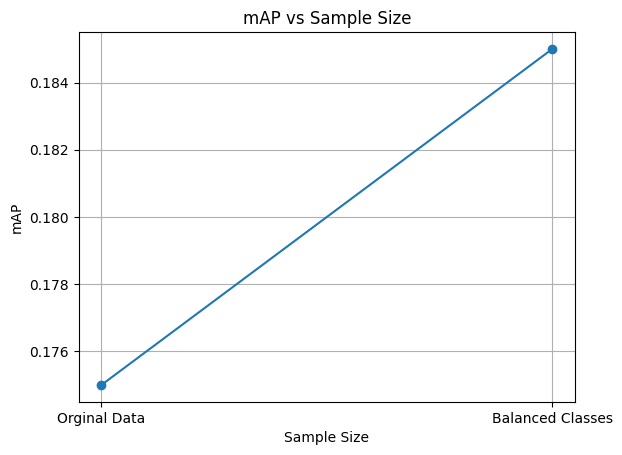

In [4]:
import matplotlib.pyplot as plt
sample_sizes = ["Orginal Data", "Balanced Classes"]   #Samples
mAP_values = [0.175, 0.185]  #  mAP values

# Plot the graph
plt.plot(sample_sizes, mAP_values, marker='o', linestyle='-')
plt.title('mAP vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('mAP')
plt.grid(True)
plt.xticks(sample_sizes)
plt.show()
